### Student Information

Name:`馬茂源`

Student ID:`107062549`

GitHub ID:`brian41005`

---

### Instructions

- First, you should attempt the **take home** exercises provided in the [notebook](https://github.com/omarsar/data_mining_lab/blob/master/news_data_mining.ipynb) we used for the first lab session. Attempt all the exercises, as it is counts towards the final grade of your first assignment (20%). 

- Then, download the dataset provided in this [link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#). The sentiment dataset contains a `sentence` and `score` label. Read the specificiations of the dataset before you start exploring it. 


- Then, you are asked to apply each of the data exploration and data operation steps learned in the [first lab session](https://github.com/omarsar/data_mining_lab) on **the new dataset**. You don't need to explain all the procedures as we did in the notebook, but you are expected to provide some **minimal comments** explaining your code. You are also expected to use the same libraries used in the first lab session. You are allowed to use and modify the `helper` functions we provided in the first lab session or create your own. Also, be aware that the helper functions may need modification as you are dealing with a completely different dataset. This part is worth 30% of your grade!

- In addition to applying the same operations from the first lab, we are asking that you attempt the following tasks on the new sentiment dataset as well (40%):
    - Use your creativity and imagination to generate **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) on how you may go about doing this. Keep in mind that you are generating a matrix similar to the term-document matrix we implemented in our first lab session. However, the weights will be computed differently and should represent the TF-IDF value of each word per document as opposed to the word frequency.
    - Using both the TF-IDF and word frequency features, try to compute the **similarity** between random sentences and report results. Read the "distance simiilarity" section of the Data Mining textbook on what measures you can use here. [Cosine similarity](https://jamesmccaffrey.wordpress.com/2017/03/29/the-cosine-similarity-of-two-sentences/) is one of these methods but there are others. Try to explore a few of them in this exercise and report the differences in result. 
    - Lastly, implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Try to implement this using scikit-learn built in classifiers and use both the TF-IDF features and word frequency features to build two seperate classifiers. Refer to this [nice article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/) on how to build this type of classifier using scikit-learn. Report the classification accuracy of both your models. If you are struggling with this step please reach us on Slack as soon as possible.   


- Presentation matters! You are also expected to **tidy up your notebook** and attempt new data operations and techniques that you have learned so far in the Data Mining course. Surprise us! This segment is worth 10% of your grade. The idea of this exercise is to begin thinking of how you will program the concepts you have learned and the process that is involved. 


- After completing all the above tasks, you are free to remove this header block and **submit** your assignment following the guide provided in the [README.md](https://github.com/omarsar/dm_2018_hw_1/blob/master/README.md) file of the assignment's repository. 

In [48]:
### Begin Assignment Here!

In [64]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
name_list = ['imdb_labelled', 'yelp_labelled' , 'amazon_cells_labelled']

In [51]:
sentiment_df = pd.concat([pd.read_csv('sentiment labelled sentences/{}.txt'.format(f_name), sep='\t', header=None)  
                          for f_name in name_list])

In [52]:
sentiment_df.columns = ['text', 'score']

In [53]:
sentiment_df.head()

,text,score
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [54]:
len(sentiment_df)

2748

## Missing values

In [55]:
sentiment_df.isnull().sum()

text     0
score    0
dtype: int64

In [56]:
sentiment_df['text'].apply(lambda t: t == None and t == np.nan and t == '').sum()

0

In [57]:
sentiment_df['score'].apply(lambda s: 0 <= s <= 1).sum()

2748

## Duplicate Data

In [58]:
sentiment_df.duplicated('text').sum()

17

In [59]:
sentiment_df['text'][sentiment_df.duplicated('text', False)]

29                      Definitely worth checking out.  
64                                               10/10  
165                     Definitely worth checking out.  
374                                   Not recommended.  
387                                   Not recommended.  
590                                              10/10  
334                                   I love this place.
380                                     I won't be back.
383                               The food was terrible.
505                    I would not recommend this place.
814                                   I love this place.
816                               The food was terrible.
843                                     I won't be back.
846                    I would not recommend this place.
18                                         Works great!.
179    If you like a loud buzzing to override all you...
180                              Don't buy this product.
187                            

In [60]:
sentiment_df.drop_duplicates('text', inplace=True)

In [63]:
len(sentiment_df) == 2731

True

## Data Preprocessing

1    1376
0    1355
Name: score, dtype: int64


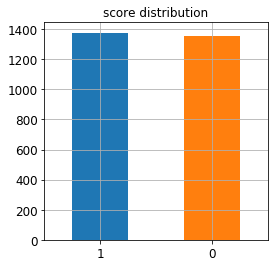

In [70]:
value_counts = sentiment_df['score'].value_counts()
print(value_counts)
y_max = value_counts.max()
value_counts.plot(kind = 'bar',
                  grid=True,
                  title = 'score distribution',
                  rot = 0, fontsize = 12, figsize = (4,4))